### in this notebook we'll explore the weighted random sampler. we'll also explore the best way to calculate weights 

Note: WeightedRandomSampler requrires a weight for each example, not for each class label. So we have to first find the class weights, and assign the class weight to each example under that class 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#### load a highly imbalanced dataset 

In [2]:
def get_filelist(dirname):
    filelist = os.listdir(dirname)
    allfiles = []
    for f in filelist:
        fullpath = f'{dirname}/{f}'
        if os.path.isdir(fullpath):
            allfiles = allfiles + get_filelist(fullpath)
        else:
            allfiles.append(fullpath)
                
    return allfiles

In [3]:
ROOTDIR = '../../../arise_datasets/Lope-Waka_256/'

In [4]:
filelist = get_filelist(ROOTDIR)

In [5]:
len(filelist)

44938

#### get the labels 

In [6]:
labels = []
for file in filelist:
    label = file.split('/')[-2]
    labels.append(label)

#### put both in a dataframe 

In [7]:
df = pd.DataFrame()

In [8]:
df['imloc'] = filelist
df['label'] = labels

In [9]:
df.head()

,imloc,label
0,../../../arise_datasets/Lope-Waka_256//Aardvar...,Aardvark
1,../../../arise_datasets/Lope-Waka_256//Aardvar...,Aardvark
2,../../../arise_datasets/Lope-Waka_256//Aardvar...,Aardvark
3,../../../arise_datasets/Lope-Waka_256//Aardvar...,Aardvark
4,../../../arise_datasets/Lope-Waka_256//Aardvar...,Aardvark


#### check the class distribution 

In [10]:
dfcount = df['label'].value_counts().to_frame().reset_index()
dfcount.columns = ['label','num_images']
dfcount

,label,num_images
0,Blank,9643
1,Duiker_Ogilby,5406
2,Elephant_African,5033
3,Duiker_Blue,4195
4,Hog_Red_River,4156
...,...,...
56,Duiker_Black_Fronted,2
57,Cusimanse,2
58,Hornbill_African_Pied,1
59,Oyan_Central_African,1


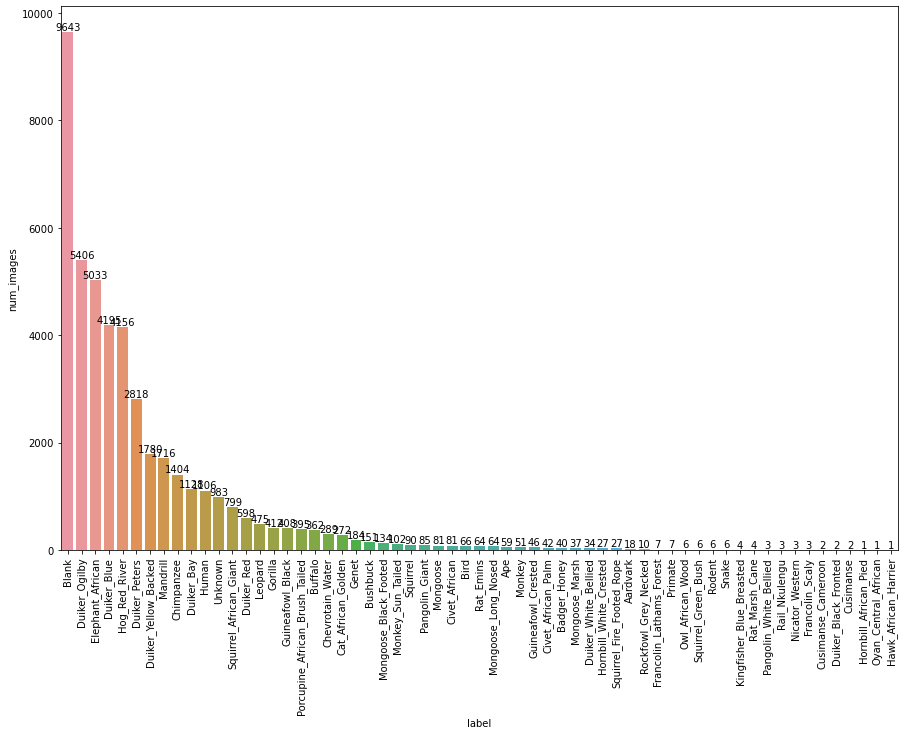

In [11]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x='label',y='num_images',data=dfcount)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()

### use WeightedRandomSampler

In [12]:
import torch
from torchvision.datasets import ImageFolder
import os
from torch.utils.data import WeightedRandomSampler, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn

#### get the weights for each class 

In [13]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize((224,224))])

In [14]:
traindataset = ImageFolder(root=ROOTDIR, transform=transform)

In [15]:
traindataset.class_to_idx

{'Aardvark': 0,
 'Ape': 1,
 'Badger_Honey': 2,
 'Bird': 3,
 'Blank': 4,
 'Buffalo': 5,
 'Bushbuck': 6,
 'Cat_African_Golden': 7,
 'Chevrotain_Water': 8,
 'Chimpanzee': 9,
 'Civet_African': 10,
 'Civet_African_Palm': 11,
 'Cusimanse': 12,
 'Cusimanse_Cameroon': 13,
 'Duiker_Bay': 14,
 'Duiker_Black_Fronted': 15,
 'Duiker_Blue': 16,
 'Duiker_Ogilby': 17,
 'Duiker_Peters': 18,
 'Duiker_Red': 19,
 'Duiker_White_Bellied': 20,
 'Duiker_Yellow_Backed': 21,
 'Elephant_African': 22,
 'Francolin_Lathams_Forest': 23,
 'Francolin_Scaly': 24,
 'Genet': 25,
 'Gorilla': 26,
 'Guineafowl_Black': 27,
 'Guineafowl_Crested': 28,
 'Hawk_African_Harrier': 29,
 'Hog_Red_River': 30,
 'Hornbill_African_Pied': 31,
 'Hornbill_White_Crested': 32,
 'Human': 33,
 'Kingfisher_Blue_Breasted': 34,
 'Leopard': 35,
 'Mandrill': 36,
 'Mongoose': 37,
 'Mongoose_Black_Footed': 38,
 'Mongoose_Long_Nosed': 39,
 'Mongoose_Marsh': 40,
 'Monkey': 41,
 'Monkey_Sun_Tailed': 42,
 'Nicator_Western': 43,
 'Owl_African_Wood': 44,
 '

#### get the class weights 

the order of the labels in dfcount should match the order of the labels in traindataset.class_to_idx

In [16]:
dfcount = dfcount.sort_values('label')

In [17]:
dfcount

,label,num_images
41,Aardvark,18
32,Ape,59
36,Badger_Honey,40
29,Bird,66
0,Blank,9643
...,...,...
25,Squirrel,90
12,Squirrel_African_Giant,799
40,Squirrel_Fire_Footed_Rope,27
46,Squirrel_Green_Bush,6


In [19]:
class_weights = []
for i in range(dfcount.shape[0]):
    class_weight = 1/dfcount.iloc[i]['num_images']
    class_weights.append(class_weight)

In [34]:
cwdict = {}
for c,w in zip(list(dfcount['label'].values), class_weights):    
    cwdict[c] = w
    print(c,w)

Aardvark 0.05555555555555555
Ape 0.01694915254237288
Badger_Honey 0.025
Bird 0.015151515151515152
Blank 0.00010370216737529814
Buffalo 0.0027624309392265192
Bushbuck 0.006622516556291391
Cat_African_Golden 0.003676470588235294
Chevrotain_Water 0.0034602076124567475
Chimpanzee 0.0007122507122507123
Civet_African 0.012345679012345678
Civet_African_Palm 0.023809523809523808
Cusimanse 0.5
Cusimanse_Cameroon 0.5
Duiker_Bay 0.0008865248226950354
Duiker_Black_Fronted 0.5
Duiker_Blue 0.00023837902264600716
Duiker_Ogilby 0.0001849796522382538
Duiker_Peters 0.00035486160397445
Duiker_Red 0.0016722408026755853
Duiker_White_Bellied 0.029411764705882353
Duiker_Yellow_Backed 0.0005617977528089888
Elephant_African 0.00019868865487780648
Francolin_Lathams_Forest 0.14285714285714285
Francolin_Scaly 0.3333333333333333
Genet 0.005434782608695652
Gorilla 0.0024271844660194173
Guineafowl_Black 0.0024509803921568627
Guineafowl_Crested 0.021739130434782608
Hawk_African_Harrier 1.0
Hog_Red_River 0.00024061597

#### now get the sample weights (weights for each image) 

In [21]:
total_images = dfcount['num_images'].sum()
total_images

44938

In [22]:
sample_weights = [0] * total_images

In [23]:
for idx, (image, label) in enumerate(traindataset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

In [24]:
sample_weights[:10]

[0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555]

In [25]:
len(sample_weights)

44938

In [26]:
len(traindataset)

44938

In [27]:
traindataset[1], sample_weights[1]

((tensor([[[0.0154, 0.0154, 0.0157,  ..., 0.0434, 0.0395, 0.0395],
           [0.0118, 0.0118, 0.0148,  ..., 0.0487, 0.0448, 0.0448],
           [0.0118, 0.0118, 0.0118,  ..., 0.0567, 0.0538, 0.0527],
           ...,
           [0.0864, 0.1154, 0.1463,  ..., 0.0821, 0.0945, 0.1008],
           [0.0803, 0.1103, 0.1452,  ..., 0.0913, 0.0928, 0.0910],
           [0.0677, 0.0977, 0.1265,  ..., 0.0952, 0.0904, 0.0875]],
  
          [[0.0154, 0.0154, 0.0157,  ..., 0.0434, 0.0395, 0.0395],
           [0.0118, 0.0118, 0.0148,  ..., 0.0487, 0.0448, 0.0448],
           [0.0118, 0.0118, 0.0118,  ..., 0.0567, 0.0538, 0.0527],
           ...,
           [0.1203, 0.1493, 0.1830,  ..., 0.0835, 0.0959, 0.1022],
           [0.1125, 0.1425, 0.1774,  ..., 0.0852, 0.0866, 0.0849],
           [0.0954, 0.1254, 0.1601,  ..., 0.0874, 0.0826, 0.0797]],
  
          [[0.0154, 0.0154, 0.0157,  ..., 0.0434, 0.0395, 0.0395],
           [0.0118, 0.0118, 0.0148,  ..., 0.0487, 0.0448, 0.0448],
           [0.0118, 0.

In [28]:
# get the label from the class index
print(list(traindataset.class_to_idx.keys())[list(traindataset.class_to_idx.values()).index(0)])

Aardvark


check if the weight for the sample matches the weight of the class in which the sample belongs

In [35]:
cwdict['Aardvark']

0.05555555555555555

**class weights were assigned to samples as sample weights successfully!**

#### create the sampler 

In [73]:
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [74]:
type(sampler)

torch.utils.data.sampler.WeightedRandomSampler

In [75]:
len(sampler), len(sample_weights)

(44938, 44938)

the num_samples parameter in WeightedRandomSampler is the number of samples you want to draw during an epoch. 
source: https://discuss.pytorch.org/t/weightedrandomsampler-batch-size-argument-vs-dataloader-batch-size/35547

#### create the dataloader 

In [79]:
batch_size = 128

In [80]:
trainloader = DataLoader(traindataset, batch_size=batch_size, sampler=sampler)

In [85]:
images, labels = next(iter(trainloader))
print(labels.tolist())

[16, 18, 50, 59, 5, 57, 16, 8, 53, 15, 11, 8, 50, 9, 9, 8, 43, 58, 21, 14, 25, 42, 40, 32, 29, 23, 39, 49, 52, 28, 57, 60, 1, 16, 22, 53, 11, 53, 0, 59, 53, 40, 23, 60, 20, 33, 34, 54, 41, 2, 58, 48, 57, 25, 9, 38, 20, 44, 46, 33, 35, 27, 24, 30, 51, 13, 17, 4, 16, 36, 39, 34, 35, 21, 38, 12, 26, 57, 33, 28, 50, 57, 1, 41, 58, 26, 17, 5, 29, 42, 18, 52, 10, 20, 17, 28, 53, 54, 51, 4, 57, 22, 36, 55, 29, 36, 59, 6, 56, 15, 48, 45, 35, 15, 14, 19, 14, 32, 30, 1, 60, 5, 38, 11, 4, 14, 41, 58]


#### experiment by running the trainloader 100 times, and plot the distribution of the labels

In [90]:
dloader_labels = []
for i in range(100):
    images, labels = next(iter(trainloader))
    dloader_labels = dloader_labels + labels.tolist()

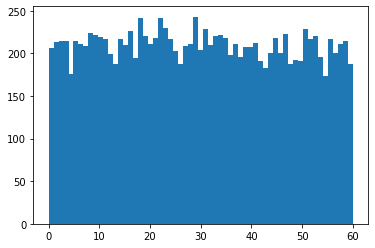

In [91]:
plt.hist(dloader_labels, bins=61)
plt.show()

In [94]:
dloader_labels_remapped = []
for l in dloader_labels:
    labtext = list(traindataset.class_to_idx.keys())[list(traindataset.class_to_idx.values()).index(l)]
    dloader_labels_remapped.append(labtext)

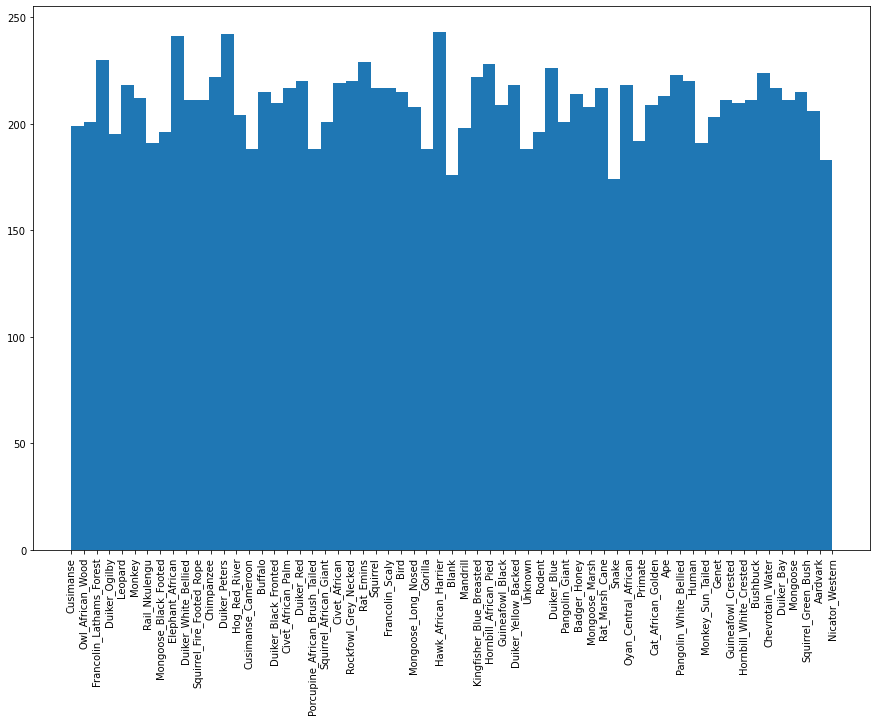

In [99]:
plt.figure(figsize=(15,10))
plt.hist(dloader_labels_remapped, bins=61)
plt.xticks(rotation=90)
plt.show()

**Great! the distribution returned by the sampler looks uniform. so the sampler works!**

Note: <br>
you may have noticed that the distribution plotted with the class ids, and the distribtution plotted with the class names look different. this is because the class ids are plotted in order, while the class names are not

In [101]:
for i,t in zip(dloader_labels[:5], dloader_labels_remapped[:5]):
    print(i, t)

12 Cusimanse
44 Owl_African_Wood
23 Francolin_Lathams_Forest
17 Duiker_Ogilby
35 Leopard


### appendix 

In [107]:
sample_label_count_dict = {}
for lab in list(set(dloader_labels_remapped)):
    sample_label_count_dict[lab] = 0

In [108]:
sample_label_count_dict

{'Pangolin_White_Bellied': 0,
 'Monkey': 0,
 'Squirrel_Fire_Footed_Rope': 0,
 'Leopard': 0,
 'Oyan_Central_African': 0,
 'Snake': 0,
 'Buffalo': 0,
 'Bushbuck': 0,
 'Rat_Marsh_Cane': 0,
 'Cusimanse': 0,
 'Hornbill_White_Crested': 0,
 'Squirrel_Green_Bush': 0,
 'Rat_Emins': 0,
 'Mongoose_Long_Nosed': 0,
 'Blank': 0,
 'Mandrill': 0,
 'Aardvark': 0,
 'Rodent': 0,
 'Duiker_Bay': 0,
 'Pangolin_Giant': 0,
 'Human': 0,
 'Duiker_Ogilby': 0,
 'Duiker_Black_Fronted': 0,
 'Mongoose': 0,
 'Hawk_African_Harrier': 0,
 'Nicator_Western': 0,
 'Hog_Red_River': 0,
 'Elephant_African': 0,
 'Owl_African_Wood': 0,
 'Duiker_Red': 0,
 'Squirrel_African_Giant': 0,
 'Squirrel': 0,
 'Hornbill_African_Pied': 0,
 'Ape': 0,
 'Cat_African_Golden': 0,
 'Guineafowl_Crested': 0,
 'Guineafowl_Black': 0,
 'Mongoose_Black_Footed': 0,
 'Monkey_Sun_Tailed': 0,
 'Duiker_White_Bellied': 0,
 'Francolin_Lathams_Forest': 0,
 'Unknown': 0,
 'Rail_Nkulengu': 0,
 'Primate': 0,
 'Rockfowl_Grey_Necked': 0,
 'Genet': 0,
 'Duiker_Blue

In [109]:
for lab in dloader_labels_remapped:
    sample_label_count_dict[lab] += 1

In [111]:
sample_label_count_dict

{'Pangolin_White_Bellied': 223,
 'Monkey': 212,
 'Squirrel_Fire_Footed_Rope': 211,
 'Leopard': 218,
 'Oyan_Central_African': 218,
 'Snake': 174,
 'Buffalo': 215,
 'Bushbuck': 211,
 'Rat_Marsh_Cane': 217,
 'Cusimanse': 199,
 'Hornbill_White_Crested': 210,
 'Squirrel_Green_Bush': 215,
 'Rat_Emins': 229,
 'Mongoose_Long_Nosed': 208,
 'Blank': 176,
 'Mandrill': 198,
 'Aardvark': 206,
 'Rodent': 196,
 'Duiker_Bay': 217,
 'Pangolin_Giant': 201,
 'Human': 220,
 'Duiker_Ogilby': 195,
 'Duiker_Black_Fronted': 210,
 'Mongoose': 211,
 'Hawk_African_Harrier': 243,
 'Nicator_Western': 183,
 'Hog_Red_River': 204,
 'Elephant_African': 241,
 'Owl_African_Wood': 201,
 'Duiker_Red': 220,
 'Squirrel_African_Giant': 201,
 'Squirrel': 217,
 'Hornbill_African_Pied': 228,
 'Ape': 213,
 'Cat_African_Golden': 209,
 'Guineafowl_Crested': 211,
 'Guineafowl_Black': 209,
 'Mongoose_Black_Footed': 196,
 'Monkey_Sun_Tailed': 191,
 'Duiker_White_Bellied': 211,
 'Francolin_Lathams_Forest': 230,
 'Unknown': 188,
 'Rail